<a href="https://colab.research.google.com/github/jhurtado19/Image-Registration-Techniques/blob/main/IR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we briefly explore several different methods of performing 2D image registration, in increasing order of difficulty

##### Setup

In [ ]:
import os
import numpy
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import scipy.optimize
from matplotlib.patches import ConnectionPatch
from scipy.optimize import least_squares
from scipy.ndimage import map_coordinates



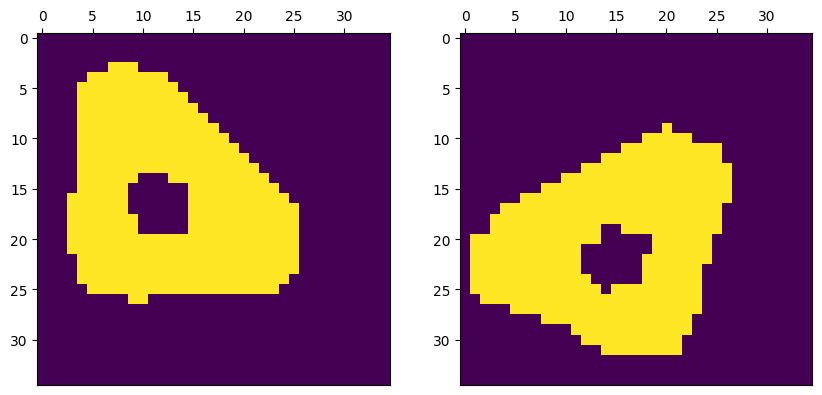

In [ ]:
## Construct two binary images
source_img = np.array([[0,0,0,0,0,0,0],[0,1,1,0,0,0,0],[0,1,1,1,0,0,0],[0,1,0,1,1,0,0],[0,1,1,1,1,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]])
source_img = scipy.ndimage.zoom(source_img, 5)
target_img = scipy.ndimage.rotate(source_img, 72, reshape = False)

def check_results(img1, img2, points1 = [], points2 = []):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.imshow(img1); ax1.xaxis.tick_top()
    ax2.imshow(img2); ax2.xaxis.tick_top()
    for p1, p2 in zip(points1, points2):
        fig.add_artist(ConnectionPatch(p1, p2, 'data', 'data', axesA=ax1, axesB=ax2, mutation_scale = 20, color = 'green', arrowstyle='-|>'));

check_results(source_img, target_img)

##### Method 1: Brute force alignment
This brute force method should iterate through all angles and computes the mean squared error between the transformed source image and the target image. We simply pick the angle with the minimum mean-squared error.

Mean Squared Erorr: 0.26693877551020406
Optimal Angle of Rotation is: 72.36180904522614


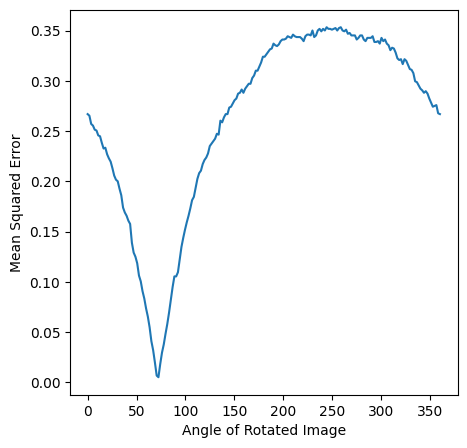

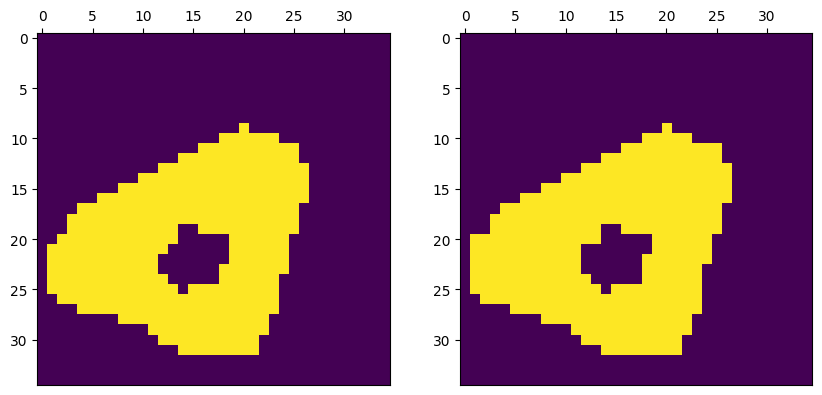

In [ ]:
# Function to rotate image
def apply_angle(img, angle):
    return scipy.ndimage.rotate(img, angle, reshape = False)


# Function to calculate Mean Squared Error (MSE)
def calc_mse(img1, img2):
    #############################################################
    #############################################################
    diff_sqr = (img2 - img1) ** 2
    mse = np.mean(diff_sqr)
    return mse


# Calcuate mse
mse = calc_mse(source_img,target_img)
print("Mean Squared Erorr:",mse)

    #############################################################


# Initialze array containing angles
angles = np.linspace(0, 360, num = 200)
# Empty array for storing mse values
mse_vals = np.zeros(angles.shape)

#Index loop to calculate mse based on angle of rotation
for idx, angle in enumerate(angles):
    ## TODO: rotate `source_img`, compute mean-squared error, and save result

    # Rotate source_img by current angle
    rotated_img = ndimage.rotate(source_img, angle, reshape = False)

    # Compute Mean Squared Error
    mse = calc_mse(target_img,rotated_img)

    # Save MSE computation
    mse_vals[idx] = mse



## for plotting mse vs. angle
plt.figure(figsize=(5,5))
plt.plot(angles, mse_vals);
plt.xlabel('Angle of Rotated Image');
plt.ylabel('Mean Squared Error');

###################################################################
# TODO: pick angle corresponding to the lowest mean squared error #
###################################################################

# get index for least MSE value
min_mse = np.argmin(mse_vals)

# get optimal angle
optim_angle = angles[min_mse]
print("Optimal Angle of Rotation is:",optim_angle)

# Results
source_img_tx1 = apply_angle(source_img, optim_angle)
check_results(source_img_tx1, target_img)
###################################################################

##### Method 2: Least squares

Although the brute force approach works, it is obviously not the optimal approach, especially if the images are more deformed/translated/scaled than this toy example. Instead, if we manually define a few pairs of points that match between the two images, we can use a least squares approach to compute a linear transformation matrix that transforms points from the source to the target image.

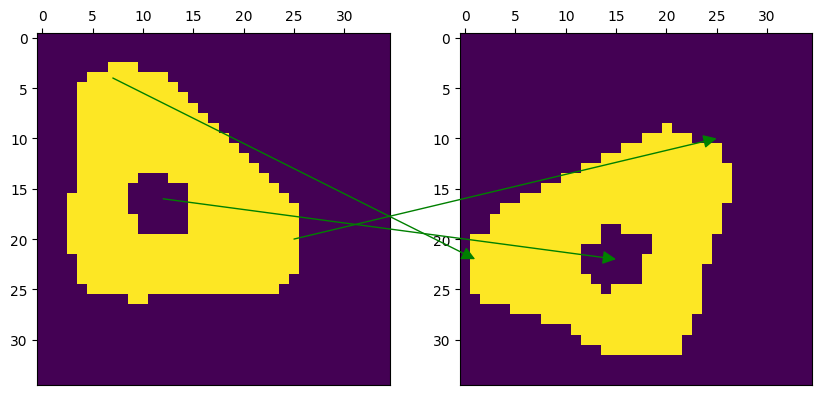

In [ ]:
## Show the mapping between the 3 source points and the 3 target points
source_points = [(12,16),(7,4),(25,20)]
target_points = [(15,22),(1,22),(25,10)]
check_results(source_img, target_img, points1 = source_points, points2 = target_points)

Transformation Matrix:
[[ 0.47058824  0.97058824 -6.17647059]
 [-1.05882353  0.44117647 27.64705883]
 [ 0.          0.          1.        ]]


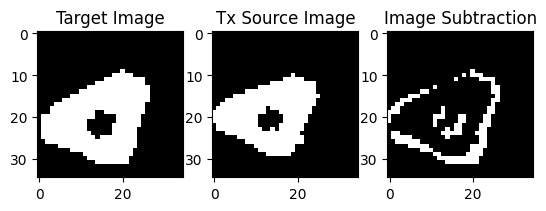

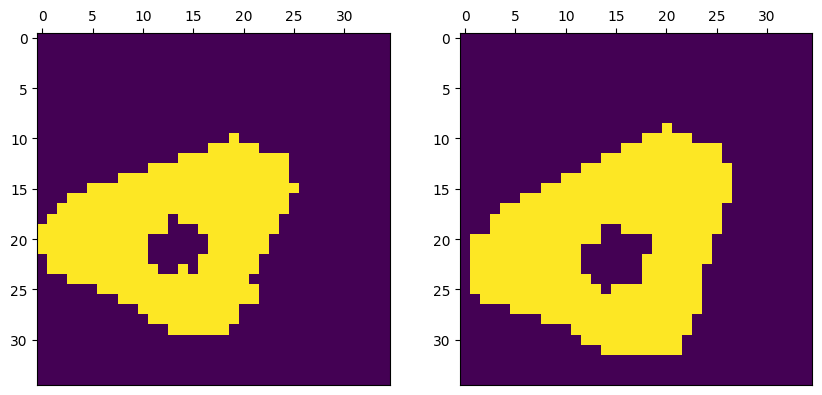

In [ ]:
#################################################################################
#################################################################################

# Function to compute affine transformation matrix using least squares
def compute_transformation_matrix(source_points, target_points):
    initial_matrix = np.eye(3).flatten()
    result = least_squares(compute_residuals, initial_matrix, args=(source_points, target_points))
    transformation_matrix = result.x.reshape((3, 3))
    return transformation_matrix

# Function to apply transformation to source image points, using augmented matrix and homogenous points
def apply_transformation_matrix(matrix, points):
    homogenous_points = np.hstack((points, np.ones((points.shape[0], 1))))
    transformed_points = np.dot(homogenous_points, matrix.T)
    return transformed_points[:, :2]

# Function to compute residuals and transform source points to target space
def compute_residuals(flat_matrix, source_points, target_points):
    matrix = flat_matrix.reshape((3, 3))
    transformed_source_points = apply_transformation_matrix(matrix, source_points)
    return (transformed_source_points - target_points).flatten()

# Function to generate transformed image, and assign pixel values based on cubic interpolation
def transform_image(source_image, transformation_matrix, target_shape):
    height, width = target_shape
    x, y = np.indices(target_shape)


    # Transform the grid points of the target image
    xy_target = np.column_stack([x.ravel(), y.ravel(), np.ones(x.size)])
    xy_source = np.dot(xy_target, transformation_matrix.T)[:, :2]

    # Clip the transformed coordinates to fit within the source image boundaries
    xy_source[:, 0] = np.clip(xy_source[:, 0], 0, source_image.shape[1] - 1)
    xy_source[:, 1] = np.clip(xy_source[:, 1], 0, source_image.shape[0] - 1)

    # Perform cubic interpolation to get the warped source image
    transformed_source_image = map_coordinates(source_image, xy_source.T, order=3, mode='nearest').reshape(target_shape)

    return transformed_source_image

# Source and Target points converted to np.array for computation
source_points = np.array([(12, 16), (7, 4), (25, 20)])
target_points = np.array([(15, 22), (1, 22), (25, 10)])

# Compute the transformation matrix
transformation_matrix = compute_transformation_matrix(source_points, target_points)
print("Transformation Matrix:")
print(transformation_matrix)

# Apply the transformation matrix to the source image
source_img_tx3 = transform_image(source_img, transformation_matrix, target_img.shape)

# Perform image subtraction
subtracted_image = np.abs(target_img - source_img_tx3)

# Plot results for comparison
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(target_img, cmap='gray')
plt.title('Target Image')

plt.subplot(1, 3, 2)
plt.imshow(source_img_tx3, cmap='gray')
plt.title('Tx Source Image')

plt.subplot(1, 3, 3)
plt.imshow(subtracted_image, cmap='gray')
plt.title('Image Subtraction')

plt.show()

check_results(source_img_tx3, target_img) # the images should (almost) look the same
#####################################################

##### Method 3: Optimization

If we don't have a list of points but still want a transformation matrix, an alternative is an optimization approach, such as gradient descent.
We need to first define a similarity metric to minimize between the two images (for example: mean-squared error), and then we compute the gradient of this metric with respect to each of our transformation matrix elements. In each iteration of this algorithm, we apply an update to each matrix element based on the gradient value.

Optimized Affine Transformation Parameters:  [1. 0. 0. 1. 0. 0.]
Mean Squared Error (MSE) after Registration:  0.26693877551020406


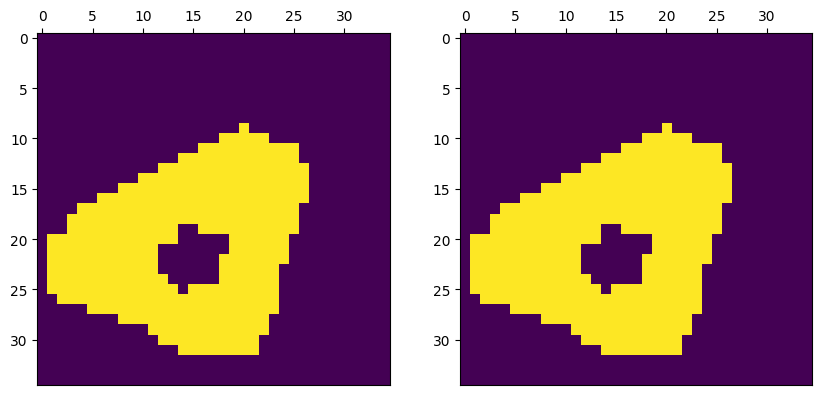

In [ ]:
###################################################################################################################################
# TODO: this exercise is more open-ended. Feel free to use any built-in gradient-based optimizer available through NumPy or SciPy #
###################################################################################################################################

# Define Mean Squared Error (MSE) cost function to minimize
def mse_cost_function(params, source_img, target_img):
    # Transformation parameters
    a, b, c, d, e, f = params

    # Create affine transformation matrix
    transformation_matrix = np.array([[a, b, e], [c, d, f], [0, 0, 1]])

    # Apply affine transformation to target image
    transformed_target = scipy.ndimage.affine_transform(target_img, transformation_matrix, mode='constant', cval=0)

    # Calculate the Mean Squared Error (MSE)
    return np.mean((source_img - transformed_target)**2)

# Initial affine transformation parameters (a, b, c, d, e, f)
initial_params = [1.0, 0.0, 0.0, 1.0, 0.0, 0.0]

# Perform optimization using gradient descent
result = scipy.optimize.minimize(mse_cost_function, initial_params, args=(source_img, target_img), method='L-BFGS-B')

# Get optimized affine transformation parameters
optimized_params = result.x

# Extract elements of the transformation matrix from optimized parameters
a_opt, b_opt, c_opt, d_opt, e_opt, f_opt = optimized_params

# Create optimized affine transformation matrix
optimized_transformation_matrix = np.array([[a_opt, b_opt, e_opt], [c_opt, d_opt, f_opt], [0, 0, 1]])

# Apply optimized affine transformation to the target image
registered_img = scipy.ndimage.affine_transform(target_img, optimized_transformation_matrix, mode='constant', cval=0)

# Results
print("Optimized Affine Transformation Parameters: ", optimized_params)
print("Mean Squared Error (MSE) after Registration: ", result.fun)

source_img_tx3 = registered_img
check_results(source_img_tx3, target_img)
###################################################################################################################################